In [95]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_a_priori_probability(dataset, class_number):
    num_samples = dataset.shape[0]
    class_samples = dataset[dataset[:, 0] == class_number]
    class_sample_count = class_samples.shape[0]
    return class_sample_count/num_samples

def get_sample_mean(dataset, class_number):
    class_samples = dataset[dataset[:,0] == class_number] # extract data only for the given class
    class_samples = class_samples[:, 1:] # remove the first column (the assigned class)
    mu = np.mean(class_samples, axis = 0) # get the mean of the samples
    return mu

def get_sample_variance(dataset, class_number, mu):
    class_samples = dataset[dataset[:, 0] == class_number, 1:]
    mean_centered_samples = class_samples - mu
    n_samples = class_samples.shape[0]
    variance = np.dot(mean_centered_samples.T, mean_centered_samples) / n_samples
    return variance

def get_W_matrix(sigma):
    return -(1/2)*np.linalg.inv(sigma)

def get_w_vector(sigma, mu):
    return np.linalg.inv(sigma)@mu

def get_w0(sigma, mu, P_class):
    return -(1/2)*mu.T@np.linalg.inv(sigma)@mu - (1/2)*np.log(np.linalg.det(sigma)) + np.log(P_class)

def g_i(sample, W_i, w_i, w_i_0):
    return sample.T@W_i@sample + w_i.T@sample + w_i_0

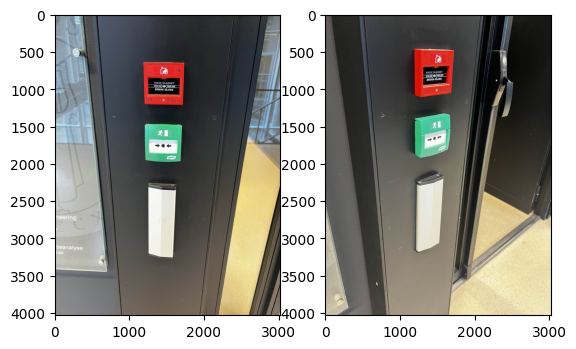

In [96]:
train_path = "data/bilde_tren.jpg"
test_path = "data/bilde_test.jpg"

img_train = cv2.imread(train_path)
img_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2RGB)
img_train = img_train.astype(float)
img_train = img_train/255

img_test = cv2.imread(test_path)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test = img_test.astype(float)
img_test = img_test/255

plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(img_train)
plt.subplot(1, 2, 2)
plt.imshow(img_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


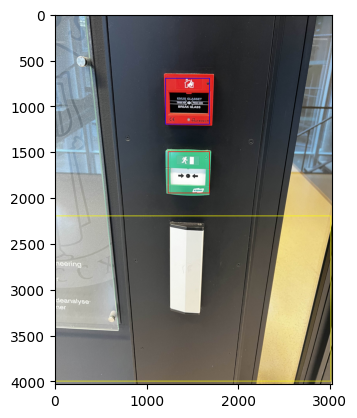

In [97]:
# class_1 = brannalarm
# class_2 = nødutgang
# class_3 = background
class_1_region = [[1200, 700], [1680, 1200]]
class_2_region = [[1230, 1500], [1680, 1950]]
class_3_region = [[0, 2200], [3000, 4000]]
img_boxed = img_train.copy()
img_boxed = cv2.rectangle(img_boxed, class_1_region[0], class_1_region[1], [0, 0, 255], 5)
img_boxed = cv2.rectangle(img_boxed, class_2_region[0], class_2_region[1], [255, 0, 0], 5)
img_boxed = cv2.rectangle(img_boxed, class_3_region[0], class_3_region[1], [255, 255, 0], 5)
plt.imshow(img_boxed)



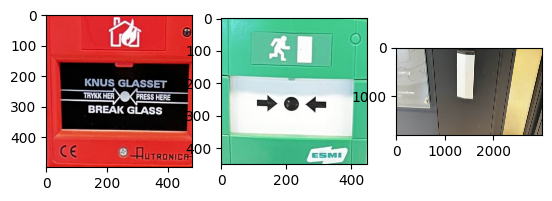

In [98]:
img_class_1 = img_train[class_1_region[0][1]:class_1_region[1][1], class_1_region[0][0]:class_1_region[1][0]]
img_class_2 = img_train[class_2_region[0][1]:class_2_region[1][1], class_2_region[0][0]:class_2_region[1][0]]
img_class_3 = img_train[class_3_region[0][1]:class_3_region[1][1], class_3_region[0][0]:class_3_region[1][0]]

plt.subplots(1, 3)
plt.subplot(1, 3, 1)
plt.imshow(img_class_1)
plt.subplot(1, 3, 2)
plt.imshow(img_class_2)
plt.subplot(1, 3, 3)
plt.imshow(img_class_3)

In [99]:
class_1_intensities = img_class_1[:,:,0] + img_class_1[:,:,1] + img_class_1[:,:,2] + 1e-9
class_2_intensities = img_class_2[:,:,0] + img_class_2[:,:,1] + img_class_2[:,:,2] + 1e-9
class_3_intensities = img_class_3[:,:,0] + img_class_3[:,:,1] + img_class_3[:,:,2] + 1e-9

class_1_t1 = img_class_1[:,:,0]/class_1_intensities
class_1_t2 = img_class_1[:,:,1]/class_1_intensities
class_1_samples = np.dstack((class_1_t1, class_1_t2))

class_2_t1 = img_class_2[:,:,0]/class_2_intensities
class_2_t2 = img_class_2[:,:,1]/class_2_intensities
class_2_samples = np.dstack((class_2_t1, class_2_t2))

class_3_t1 = img_class_3[:,:,0]/class_3_intensities
class_3_t2 = img_class_3[:,:,1]/class_3_intensities
class_3_samples = np.dstack((class_3_t1, class_3_t2))

class_1_samples = class_1_samples.reshape(-1, class_1_samples.shape[-1])
class_2_samples = class_2_samples.reshape(-1, class_2_samples.shape[-1])
class_3_samples = class_3_samples.reshape(-1, class_3_samples.shape[-1])

class_1_samples = np.column_stack((1*np.ones(len(class_1_samples)), class_1_samples))
class_2_samples = np.column_stack((2*np.ones(len(class_2_samples)), class_2_samples))
class_3_samples = np.column_stack((3*np.ones(len(class_3_samples)), class_3_samples))

training_set = np.vstack((class_1_samples, class_2_samples, class_3_samples))

In [100]:
P_class_1 = get_a_priori_probability(training_set, 1)
P_class_2 = get_a_priori_probability(training_set, 2)
P_class_3 = get_a_priori_probability(training_set, 3)
mu_1 = get_sample_mean(training_set, 1)
mu_2 = get_sample_mean(training_set, 2)
mu_3 = get_sample_mean(training_set, 3)
sigma_1 = get_sample_variance(training_set, 1, mu_1)
sigma_2 = get_sample_variance(training_set, 2, mu_2)
sigma_3 = get_sample_variance(training_set, 3, mu_3)
W_1 = get_W_matrix(sigma_1)
W_2 = get_W_matrix(sigma_2)
W_3 = get_W_matrix(sigma_3)
w_1 = get_w_vector(sigma_1, mu_1)
w_2 = get_w_vector(sigma_2, mu_2)
w_3 = get_w_vector(sigma_3, mu_3)
w_1_0 = get_w0(sigma_1, mu_1, P_class_1)
w_2_0 = get_w0(sigma_2, mu_2, P_class_2)
w_3_0 = get_w0(sigma_3, mu_3, P_class_3)

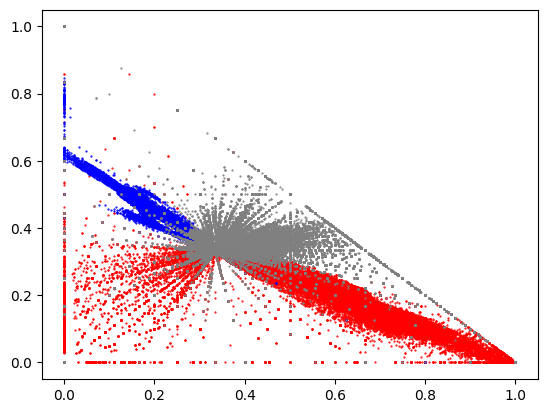

In [101]:
plt.scatter(class_1_t1, class_1_t2, color='r', s=0.3)
plt.scatter(class_2_t1, class_2_t2, color='b', s=0.3)
plt.scatter(class_3_t1, class_3_t2, color='grey', s=0.3)

In [102]:
result_img = np.zeros_like(img_test)
cols, rows, chans = result_img.shape
class_1_highlight = np.array([1, 0, 0])
class_2_highlight = np.array([0, 1, 0])
class_3_highlight = np.array([0.5, 0.5, 0.5])

for i in range(cols):
    for j in range(rows):
        pixel = img_test[i, j, :]
        # transform to feature space
        intensity = np.sum(pixel)
        if intensity == 0:
            sample = np.array([0, 0])
        else:
            sample = np.array([pixel[0], pixel[1]])/intensity
        g_1 = g_i(sample, W_1, w_1, w_1_0)
        g_2 = g_i(sample, W_2, w_2, w_2_0)
        g_3 = g_i(sample, W_3, w_3, w_3_0)
        if (g_1 > g_2) and (g_1 > g_3):
            result_img[i, j] = class_1_highlight
        elif (g_2 > g_1) and (g_2 > g_3):
            result_img[i, j] = class_2_highlight
        else:
            result_img[i, j] = class_3_highlight

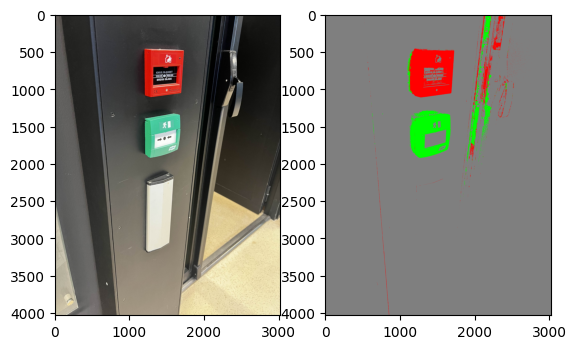

In [103]:
plt.subplots(1, 2)
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.subplot(1, 2, 2)
plt.imshow(result_img)